In [1]:
import logging
logging.root.setLevel(logging.INFO)


In [2]:
import random

from xcs import XCSAlgorithm
from xcs.scenarios import Scenario

In [3]:
import random

from xcs.scenarios import Scenario
from xcs.bitstrings import BitString

# environment setup
import gym
# noinspection PyUnresolvedReferences
import gym_maze

from utils.xcs_utils import *

In [4]:
exploration_cycles = 4000
exploitation_cycles = 1000

input_size = 8
logging.root.setLevel(logging.INFO)
scenario = MazeScenario(input_size)

In [5]:
import numpy as np
algorithm = XCSAlgorithm()
algorithm.max_population_size = 1600          # N
algorithm.learning_rate = .2                 # beta
algorithm.accuracy_coefficient = .1          # alpha
algorithm.error_threshold = .01              # epsilon_0
algorithm.accuracy_power = 5                 # nu
algorithm.discount_factor = .71              # gamma
algorithm.ga_threshold = 35                  # theta_GA
algorithm.crossover_probability = .8         # chi
algorithm.mutation_probability = .01         # mu
algorithm.deletion_threshold = 20            # theta_del
algorithm.fitness_threshold = .1             # delta
algorithm.subsumption_threshold = 20         # theta_sub
algorithm.wildcard_probability = .3          # P_#
algorithm.initial_prediction = 10        # p_I
algorithm.initial_error = .00001             # epsilon_I
algorithm.initial_fitness = 10           # F_I
algorithm.exploration_probability = .5       # p_exp
algorithm.minimum_actions = 8             # theta_mna
algorithm.do_ga_subsumption = False          # doGASubsumption
algorithm.do_action_set_subsumption = False  # doActionSetSubsumption

In [6]:
other_metrics = other_avg_experiment(
                                     maze=scenario,
                                     algorithm=algorithm,
                                     number_of_tests=2,
                                     explore_trials=exploration_cycles,
                                     exploit_trials=exploitation_cycles
                                    )


Executing 0 experiment
Executing 1 experiment


In [7]:
display(other_metrics)

,steps_in_trial,population,numerosity
trial,,,
0,37.5,36.0,37.0
100,36.5,436.0,1600.0
200,23.0,537.5,1600.0
300,26.5,534.0,1600.0
400,12.0,541.5,1600.0
500,5.5,525.5,1600.0
600,50.0,487.0,1600.0
700,18.5,459.5,1600.0
800,28.0,428.5,1600.0


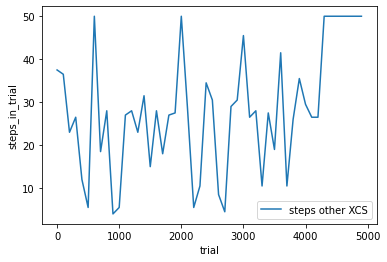

In [8]:
import pandas as pd

ax = other_metrics["steps_in_trial"].plot()
ax.set_xlabel("trial")
ax.set_ylabel("steps_in_trial")
ax.legend(["steps other XCS"])

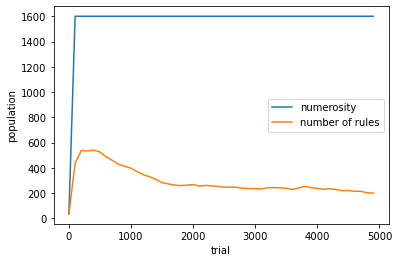

In [9]:
ax = other_metrics[['numerosity', 'population']].plot()
ax.set_xlabel("trial")
ax.set_ylabel("population")
ax.legend(["numerosity", "number of rules"])

In [10]:
from lcs.agents.xcs import Configuration

cfg = Configuration(
    number_of_actions=algorithm.minimum_actions,
    metrics_trial_frequency=100,
    covering_wildcard_chance=1-algorithm.wildcard_probability,
    max_population=algorithm.max_population_size,
    learning_rate=algorithm.learning_rate,
    alpha=algorithm.accuracy_coefficient,
    epsilon_0=algorithm.error_threshold,
    v=algorithm.accuracy_power,
    gamma=algorithm.discount_factor,
    ga_threshold=algorithm.ga_threshold,
    chi=algorithm.crossover_probability,
    mutation_chance=algorithm.mutation_probability,
    deletion_threshold=algorithm.deletion_threshold,
    delta=algorithm.fitness_threshold,
    subsumption_threshold=algorithm.subsumption_threshold,
    initial_prediction=algorithm.initial_prediction,
    initial_error=algorithm.initial_error,
    initial_fitness=algorithm.initial_fitness,
    epsilon=algorithm.exploration_probability,
    user_metrics_collector_fcn=xcs_metrics)



In [ ]:
my_metrics = avg_experiment(scenario,
                    cfg,
                    number_of_tests=2,
                    explore_trials=exploration_cycles,
                    exploit_metrics=exploitation_cycles,
                    )


INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 50, 'reward': [1631.9760602461931, 184.63689514930772, 908.0574351818735, 63.345367277620994, 221.79639072107003, 2039.5832761574534, 1707.1241019799998, 5412.924779436832], 'perf_time': 0.015201000000047316, 'population': 70, 'numerosity': 70}


Executing 0 experiment


INFO:lcs.agents.Agent:{'trial': 400, 'steps_in_trial': 50, 'reward': [5.015948264654275e+140, 1.6686500256505748e+140, 9.092811131373057e+140, 4.014581644828709e+140, 4.5254441889353626e+140, 1.1612715754276093e+141, 9.793244228443746e+139, 2.5211991980682765e+140], 'perf_time': 0.048124499999971704, 'population': 225, 'numerosity': 1600}
INFO:lcs.agents.Agent:{'trial': 800, 'steps_in_trial': 50, 'reward': [8.070208548539359e+292, 8.981460483721388e+292, 5.328999517594904e+292, 1.7110414761797805e+292, 1.4958822902614845e+292, 3.734516224047658e+292, 2.596692135882429e+291, 4.266999573737909e+292], 'perf_time': 0.06813109999995959, 'population': 276, 'numerosity': 1600}
INFO:lcs.agents.Agent:{'trial': 1200, 'steps_in_trial': 23, 'reward': [0, 0, 0, 0, 0, 0, 0, 0], 'perf_time': 0.027551200000061726, 'population': 277, 'numerosity': 1600}
INFO:lcs.agents.Agent:{'trial': 1600, 'steps_in_trial': 50, 'reward': [0, 0, 0, 0, 0, 0, 0, 0], 'perf_time': 0.12411320000001069, 'population': 265, 'n

Executing 1 experiment


INFO:lcs.agents.Agent:{'trial': 400, 'steps_in_trial': 50, 'reward': [1.6088481061371442e+135, 4.7136464506352835e+135, 5.907279459274385e+135, 3.968936163131029e+135, 1.4570893764096138e+134, 5.228321874734649e+135, 1.642489206561433e+135, 2.5069012036016237e+135], 'perf_time': 0.07001800000000458, 'population': 237, 'numerosity': 1600}
INFO:lcs.agents.Agent:{'trial': 800, 'steps_in_trial': 50, 'reward': [7.383880024489049e+278, 1.4196533793830406e+278, 9.299649818509565e+277, 2.6392763909301836e+278, 3.057328983312997e+279, 6.883303424007693e+278, 1.267962995478898e+279, 6.387433934096784e+278], 'perf_time': 0.06864460000008421, 'population': 280, 'numerosity': 1600}
INFO:lcs.agents.Agent:{'trial': 1200, 'steps_in_trial': 26, 'reward': [0, 0, 0, 0, 0, 0, 0, 0], 'perf_time': 0.03018140000006042, 'population': 281, 'numerosity': 1600}
INFO:lcs.agents.Agent:{'trial': 1600, 'steps_in_trial': 9, 'reward': [0, 0, 0, 0, 0, 0, 0, 0], 'perf_time': 0.016185899999982212, 'population': 263, 'num

In [ ]:
display(my_metrics)

In [ ]:
import pandas as pd

ax = my_metrics['steps_in_trial'].plot()
ax.set_xlabel("trial")
ax.set_ylabel("steps in trial")
ax.legend(["steps"])

In [ ]:
ax = my_metrics[['numerosity', 'population']].plot()
ax.set_xlabel("trial")
ax.set_ylabel("population")
ax.legend(["numerosity", "number of rules"])